In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 4
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c5_img20250512-12_06_55CEST.jpg"
overlay_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c5_img20250512-11_57_42CEST.jpg"

delta_pitch_deg=0.0
delta_yaw_deg=-3.0 
delta_roll_deg=-3.0 
delta_r=0.000

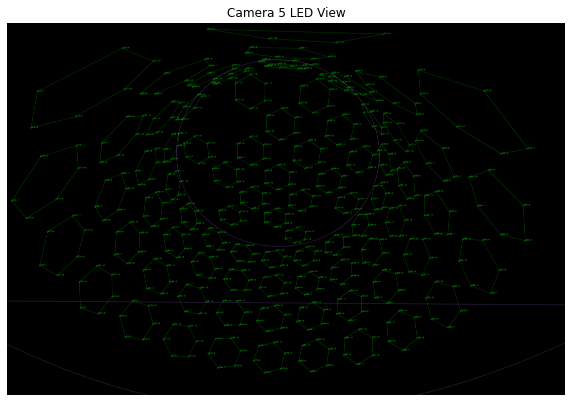

Saved image to camera5_f3253_p0_y-3_r-3_dr0.png


In [3]:
excluded_pmts = { 5, 9, 12, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 
                 30, 32, 35, 38, 39, 40, 41, 45, 54, 55, 56, 57, 
                 63, 71, 74, 77, 79}
#for delta_pitch_deg in [-5, 0, 5]:
#    for delta_yaw_deg in [-3, 0, 3]:
#        for delta_roll_deg in [-3, 0, 3]:
prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts={})

In [4]:

blobs = prim.run_blob_detector( cur_cam_index, image_filename_current, minarea=20, maxarea=5000, minthres=20, maxthres=255 )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 50)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 306
number of blobs: 298


In [5]:
prim.draw_image_with_blobs_save( cur_cam_index, image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c5_with_blob_annotation.jpg


In [6]:
# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

control_points = {
    '076-11': (2209, 4591),
    '068-8': (7464, 3292),
    '007-6': (4860, 2902),
}

matches, fitpars = prim.match_blobs(
                            blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, 
                            excluded_pmts=excluded_pmts,
                            bounds = [
                                        (-15, 15),   # delta_pitch_deg
                                        (-10, -10),   # delta_yaw_deg
                                        (-10, -10),   # delta_roll_deg
                                        (-0.01, 0.01), # delta_r in meters
                                        (-0.082, 0.086), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
                                        (-0.007, 0.009), # k2
                                        (-0.0005, 0.0008), # k3
                                        (-0.0001, 0.0002)   ],

                            control_points=control_points,  
                            use_lm=True )
                                   

In [7]:
fitpars

{'delta_pitch_deg': 0.4501483676574713,
 'delta_yaw_deg': -2.4313853835221764,
 'delta_roll_deg': -4.792947017622175,
 'delta_r': -0.06824762739447045,
 'D_fit': array([ 0.18570052, -0.29230925,  0.26511817, -0.07627891]),
 'chi2': 7340658.514999043,
 'success': True}

In [8]:
len(matches)

245

In [9]:
matches

[('000-7', 4862.953, 2514.8838),
 ('000-8', 4672.096, 2394.3696),
 ('000-9', 4466.1523, 2482.8809),
 ('000-11', 4636.692, 2814.3438),
 ('001-6', 5361.2256, 2371.9983),
 ('001-7', 5403.1597, 2143.209),
 ('001-8', 5205.2104, 1998.4042),
 ('001-9', 4967.309, 2095.2239),
 ('001-11', 5132.929, 2461.1545),
 ('002-7', 4973.4053, 1616.1917),
 ('002-8', 4761.389, 1466.0361),
 ('002-9', 4522.6167, 1573.2379),
 ('002-11', 4710.539, 1984.0476),
 ('003-6', 3998.2217, 2019.7572),
 ('003-7', 4000.2385, 2254.855),
 ('003-10', 4438.4233, 2047.8014),
 ('003-11', 4219.908, 1909.7789),
 ('004-6', 3575.1716, 2427.866),
 ('004-7', 3594.5356, 2635.2778),
 ('004-9', 3979.1895, 2656.5693),
 ('004-10', 3970.698, 2448.1484),
 ('004-11', 3763.6426, 2328.7034),
 ('006-6', 4422.7056, 3196.7507),
 ('006-7', 4416.6196, 3356.1692),
 ('006-8', 4586.1167, 3448.275),
 ('006-9', 4766.4194, 3384.2756),
 ('006-10', 4782.8057, 3226.2292),
 ('006-11', 4608.5376, 3127.8555),
 ('007-6', 4859.953, 2901.2175),
 ('007-7', 4836.685

In [28]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts,
    control_points=control_points,
    overlay_image_name=overlay_filename_current,
    alpha=0.2
)


{'delta_pitch_deg': 0.4501483676574713, 'delta_yaw_deg': -2.4313853835221764, 'delta_roll_deg': -4.792947017622175, 'delta_r': -0.06824762739447045, 'D_fit': array([ 0.18570052, -0.29230925,  0.26511817, -0.07627891]), 'chi2': 7340658.514999043, 'success': True}
Overlay image saved to: c5_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {5, 9, 12, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 30, 32, 35, 38, 39, 40, 41, 45, 54, 55, 56, 57, 63, 71, 74, 77, 79}
geo_file= wcte_geometry_file.json
Sample matches labels: [('000-7', 4862.953, 2514.8838), ('000-8', 4672.096, 2394.3696), ('000-9', 4466.1523, 2482.8809), ('000-11', 4636.692, 2814.3438), ('001-6', 5361.2256, 2371.9983), ('001-7', 5403.1597, 2143.209), ('001-8', 5205.2104, 1998.4042), ('001-9', 4967.309, 2095.2239), ('001-11', 5132.929, 2461.1545), ('002-7', 4973.4053, 1616.1917)]
Sample label_to_sim keys: ['000-6', '000-7', '000-8', '000-9', '000-10', '000-11', '001-6', '001-7', '001-8', '001-9']
Saved results to c5_img20250512-12_06_55CEST.json
